In [1]:
import gym 
import itertools 
import matplotlib 
import matplotlib.style 
import numpy as np 
import pandas as pd 
import sys 
  
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Notes Before Assignment
https://www.geeksforgeeks.org/q-learning-in-python/)/

- Reinforcement learning is where an agent learns overtime to behave optimally in an invironment by interacting with it
- States are the situations the agent finds itself in during its interaction with the environment

### Q-Learning
Basic form of reinforcement learning which uses Q-Values (action values) to iteratively improve the behavior of the learning agent

### Q-Values: 
defined for states and actions, they are an estimation of how good it is to take the action A at state S - denoted Q(S, A)

### Rewards and Episodes
- An agent over the course of its lifetime starts from a state, makes a number of transitions, and at every transition, the agent takes an action, observes a reward from the environment, and then transits to another state
- If at any point of time the agent ends up in one of the terminating states that means there are no further transitions possible. This is said to be the completion of the episode

### Temporal Difference or TD-Update
An update rule to estimate the value of Q is applied at every time step of the agent's interaction with the environment

- S : Current State of the agent.
- A : Current Action Picked according to some policy.
- S' : Next State where the agent ends up.
- A' : Next best action to be picked using current Q-value estimation, i.e. pick the action with the maximum Q-value in the next state.
- R : Current Reward observed from the environment in Response of current action.
- gamma(>0 and <=1) : Discounting Factor for Future Rewards. Future rewars are less valuable than current rewards so they must be discounted. Since Q-value is an estimation of expected rewards from a state, discounting rule applies here as well.
- alpha : Step length taken to update the estimation of Q(S, A).

### Choosing the action to take using epsilon-greedy policy
- Epsilon-greedy policy is a simple policy of choosing actions using the current Q-Value estimations

Rules:
- With probability (1-epsilon) choose the action which has the highest Q-value.
- With probability (epsilon) choose any action at random.

# Assignment
The coding exercise of this week is using q-learning to solve the FrozenLake environment. This article (https://www.geeksforgeeks.org/q-learning-in-python/) will be helpful.

# Notes

- The frozen lake problem is a unique environment whereby there is only one possibility to get a reward - to win the game
- The update process therefore must consist of random movements until the agent seemingly randomly wins the game
- After it has won once, the state before the winning state is updated with information that it's also a good state to go towards
- The next advancement in judgement is when the agent finds himself next to the state that's next to the winning state. At this point the state next to the state next to the target is updated with information that it's rewarding to go towards (increased Q value)
- This process continues untill there's a "hot path" defined from the start of the level to the end

### Create Environment

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
defaultdict(lambda: np.zeros(env.action_space.n))

defaultdict(<function __main__.<lambda>()>, {})

### Create Epsilon-Greedy Policy

In [4]:
def create_epsilon_greedy_policy(Q, epsilon, num_actions):
    
    # Epsilon-greedy policy is already embedded in frozen lake environment
    # Just return the argmax of the Q-state
    def policy_function(state):
        
        action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        action_probabilities[best_action] += (1.0 - epsilon) 
        return action_probabilities 
    
    return policy_function

### Helper Functions

In [5]:
def same_row(start_state, end_state):
    if start_state in range(4) and end_state in range(4):
        return True
    elif start_state in range(4, 8) and end_state in range(4, 8):
        return True
    elif start_state in range(8, 12) and end_state in range(8, 12):
        return True
    elif start_state in range(12, 16) and end_state in range(12, 16):
        return True
    else:
        return False

In [6]:
def where_did_you_go(start_state, end_state):
    """
    Up = 3
    Right = 2
    Down = 1
    Left = 0
    Didn't move = -1
    """
    if start_state == end_state:
        return -1
    elif same_row(start_state, end_state):
        if end_state > start_state:
            return 2
        else:
            return 0
    else:
        if end_state > start_state:
            return 1
        else:
            return 3

### Build Q-Learning Model

In [7]:
def q_learning(env, num_episodes, discount_factor=0.8, alpha=1, epsilon=0.1, chunk_size=100, hole_reward=-0.1):
    
    """
    Store Q-Values for each state and action
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  
    
    """
    Store useful statistics
    """
    stats = {
        'reward': [],
        'group_range': [],
        'completion_time': []
    }
    
    """
    Define the policy
    """
    policy = create_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    """
    Keep track of what episode range we're in
    """
    group_range = "0-{}".format(chunk_size)
    
    for episode in range(num_episodes):
        
        if (episode+1) % chunk_size == 0:
            group_range = group_range.split('-')[1] + "-{}".format(episode+1)
        
        state = env.reset()
        
        for t in itertools.count():
            
            """
            Retrieve desired actions as an array of probabilities
            """
            action_probabilities = policy(state) 
   
            """
            Randomly choose action from the probability distribution
            Higher probabilities to certain actions will increase probability of acting in this way
            """
            intended_action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities) 
            
            """
            Your reward is calculated immediately after that action is taken
            """
            next_state, reward, done, _ = env.step(intended_action)
            
            """
            Calculate the direction you actually went (you might have slipped)
            """
            actual_action = where_did_you_go(state, next_state)
            if actual_action == -1:
                # Don't update TD if you didn't move
                continue
            
            """
            Make the reward negative if you fell in the hole
            """
            if done and reward == 0:
                reward = hole_reward
            
            """
            TD Update 
            1) Find the best action for the next state
            2) Create td_target which is a combination of the current movement's reward, 
            and a multiple of the Q value of the next states best move
            3) Update the state before the action with a multiple of td_target
            """
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            Q[state][actual_action] = Q[state][actual_action] + alpha * (td_target - Q[state][actual_action])
   
            """
            Leave if you win or fall in a hole
            """  
            if done:
                # Update Statistics
                stats['group_range'].append(group_range)
                stats['reward'].append(reward)
                if reward > 0:
                    stats['completion_time'].append(t + 1)
                    # print("Completed Successfully:", episode, t + 1)
                else:
                    stats['completion_time'].append(np.nan)
                # Leave
                break
                   
            state = next_state
            
    return Q, stats

### Run Q-Learning

In [16]:
episodes = 10_000
Q, stats = q_learning(env, episodes)

### Collect The Results and Group it

In [17]:
results = pd.DataFrame(
    {'Reward': stats['reward'],
     'Completion Time': stats['completion_time'],
     'Episode Range': stats['group_range']}
)
grp_by = results.reset_index().groupby('Episode Range')['index', 'Reward', 'Completion Time'].mean()
df_grouped = pd.DataFrame(grp_by).reset_index().sort_values(['index']).drop(['index'], axis=1).reset_index(drop=True)

### Plot Training Statistics

Text(0.5, 1.0, 'Mean Reward for grouping period of 100 episodes')

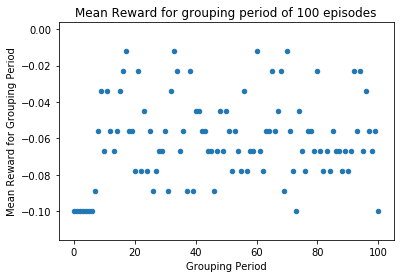

In [18]:
ax = df_grouped.reset_index().plot.scatter(x='index', y='Reward')
ax.set_ylabel('Mean Reward for Grouping Period')
ax.set_xlabel('Grouping Period')
ax.set_title("Mean Reward for grouping period of 100 episodes")

Text(0.5, 1.0, 'Mean Completion Time for grouping period of 100 episodes')

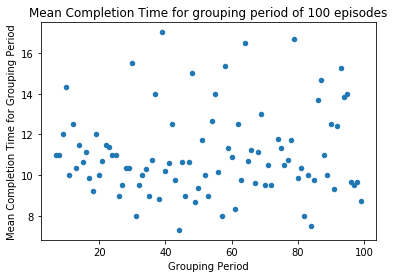

In [19]:
ax = df_grouped.reset_index().plot.scatter(x='index', y='Completion Time')
ax.set_ylabel('Mean Completion Time for Grouping Period')
ax.set_xlabel('Grouping Period')
ax.set_title("Mean Completion Time for grouping period of 100 episodes")

### From observing the data below you can see that during the episode 600-700 range the agent won it's first episode and registered a positive reward

In [23]:
df_grouped.head(20)

,Episode Range,Reward,Completion Time
0,0-100,-0.100,NaN
1,100-100,-0.100,NaN
2,100-200,-0.100,NaN
3,200-300,-0.100,NaN
4,300-400,-0.100,NaN
5,400-500,-0.100,NaN
6,500-600,-0.100,NaN
7,600-700,-0.089,11.000000
8,700-800,-0.056,11.000000
9,800-900,-0.034,12.000000


# Trained Q-Values for each state

The Q values were updated in a default dictionary where each key represents the state, and the numpy array value stores the Q-values for each direction indexed left, down, right and up ascending (see below for example)

In [24]:
schema = dict()
schema['State #'] = np.array(['Left', 'Down', 'Right', 'Up'])
schema

{'State #': array(['Left', 'Down', 'Right', 'Up'], dtype='<U5')}

In [25]:
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {0: array([0.     , 0.32768, 0.32768, 0.     ]),
             4: array([ 0.      ,  0.4096  , -0.1     ,  0.262144]),
             8: array([ 0.     , -0.1    ,  0.512  ,  0.32768]),
             12: array([0., 0., 0., 0.]),
             5: array([0., 0., 0., 0.]),
             1: array([ 0.262144, -0.1     ,  0.4096  ,  0.      ]),
             9: array([ 0.4096,  0.64  ,  0.64  , -0.1   ]),
             13: array([-0.1  ,  0.   ,  0.8  ,  0.512]),
             14: array([0.64, 0.  , 1.  , 0.64]),
             10: array([ 0.512,  0.8  , -0.1  ,  0.512]),
             2: array([0.32768, 0.512  , 0.32768, 0.     ]),
             6: array([-0.1   ,  0.64  , -0.1   ,  0.4096]),
             11: array([0., 0., 0., 0.]),
             15: array([0., 0., 0., 0.]),
             3: array([ 0.4096, -0.1   ,  0.    ,  0.    ]),
             7: array([0., 0., 0., 0.])})

### Statespace mapped for context

In [26]:
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


# Process Justification

- I began this process by implementing a basic Q-Learning model on the Frozen Lake problem
- After the basic implementation, I improved on this model by giving a negative reward to episodes where the agent fell in the hole - by default I set this reward value to be -0.1
- The default implementation punished the agent for trying to go into the hole rather than completing the level. I decided to rather than punishing the agent for where it tried to go I would punish it for it actually went
    - For example if the agent tried to go right (towards the reward) and instead it went left (towards the hole), the agent should be punished for going to the left not going to the right (it tried to go to the right but it just wasn't successful)
    - To accomplish this I developed a function to return the direction the agent actually travelled by giving it the two states (called where_did_you_go())
    - One the direction the agent actually went was computed - this was the direction that was updated in the Q Values for that initial state
    - The agent would be rewarded on where it actually went rather than where it tried to go
- Generally speaking the agent behaves very randomly up until the point it wins its first episode. Once it wins an episode it seems to quickly learn the optimal path and starts winning more frequently quite quickly